# Assignment - 7- B
## Image similarity estimation using a Siamese Network with a triplet loss

## Introduction

A [Siamese Network](https://en.wikipedia.org/wiki/Siamese_neural_network) is a type of network architecture that
contains two or more identical subnetworks used to generate feature vectors for each input and compare them.

Siamese Networks can be applied to different use cases, like detecting duplicates, finding anomalies, and face recognition.

This example uses a Siamese Network with three identical subnetworks. We will provide three images to the model, where
two of them will be similar (_anchor_ and _positive_ samples), and the third will be unrelated (a _negative_ example.)
Our goal is for the model to learn to estimate the similarity between images.

For the network to learn, we use a triplet loss function. You can find an introduction to triplet loss in the
[FaceNet paper](https://arxiv.org/pdf/1503.03832.pdf) by Schroff et al,. 2015. In this example, we define the triplet
loss function as follows:

`L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)`

## Tasks
1. Fetch the data using the following code and create tripets using the helper code. Visualize few random triplets
2. Write a code to preprocess the images. Standard preprocessing includes decoding the image, convert the dtype to float and resizing the image. Use tensorflow functions to do so and store your data in tensorflow variables rather than numpy or python lists as it is much faster.
3. Shuffle the dataset, Split into train and validation. (80-20)
4. Use a pretrained ResNet50 to obtain embeddings for images (freeze the weights). Add few Dense and Batch Norm layers at the end.  Implement triplet loss and train the model. Keep a track of val loss.
5. Now unfreeze last few layers of ResNet50 and rerun the experiment. Compare the val loss of this model with val loss of previous model(with parameters freezed).
6. Use cosine cosine similarity metric to measure how to 2 output embeddings are similar to each other. Is similiarty of  (Anchor , Positive ) > (Anchor , Negative)


## Note -

Change the runtime type to T4 GPU on your colab. Without GPU, the model takes much longer.

## Dataset
* Original Dataset - https://vis-www.cs.umass.edu/lfw/
* Fewer examples from this dataset suitable for our task is selected and is hosted in the following link.

In [1]:
!gdown 1ykjp7xHOE2TSTjcDzm6NlJRP2n_JSaBW

/bin/bash: line 1: gdown: command not found


In [2]:
!unzip /content/LFW_Trimmed_zip.zip

/bin/bash: line 1: unzip: command not found


In [3]:
image_dir = "/content/LFW_Trimmed"

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from pathlib import Path
import pandas as pd

In [5]:
filename = image_dir+"/Aaron_Peirsol/Aaron_Peirsol_0001.jpg"
pixels = plt.imread(filename)

# Show RGB shape
rgb_pixels = np.stack((pixels, pixels, pixels), axis=2)
print(rgb_pixels.shape)

# Show example image
plt.imshow(pixels)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/LFW_Trimmed/Aaron_Peirsol/Aaron_Peirsol_0001.jpg'

(250, 250, 3, 3)


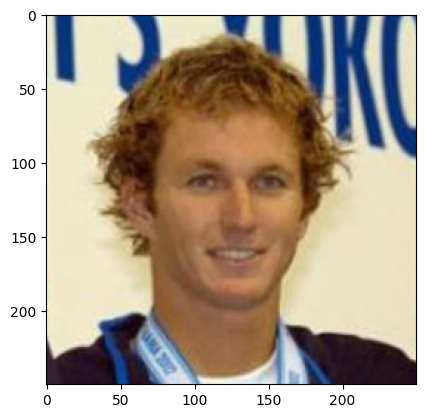

In [ ]:
filename = image_dir+"/Aaron_Peirsol/Aaron_Peirsol_0002.jpg"
pixels = plt.imread(filename)

# Show RGB shape
rgb_pixels = np.stack((pixels, pixels, pixels), axis=2)
print(rgb_pixels.shape)

# Show example image
plt.imshow(pixels)
plt.show()

In [ ]:
subjects= os.listdir(image_dir)   # list of all people
image_paths = []
for subject in subjects:
    subject_path = os.path.join(image_dir, subject)
    for filename in os.listdir(subject_path):
        full_path = os.path.join(subject_path, filename)
        image_paths.append(full_path)    # storing path for each and every image in image paths


#photos_list_flatten = [item for sublist in photos_list for item in sublist]
print(len(subjects))
print(subjects[:5])
print(image_paths[:2])

100
['Alan_Greenspan', 'James_Kopp', 'Martha_Stewart', 'Ben_Affleck', 'Geoff_Hoon']
['/content/LFW_Trimmed/Alan_Greenspan/Alan_Greenspan_0005.jpg', '/content/LFW_Trimmed/Alan_Greenspan/Alan_Greenspan_0001.jpg']


In [ ]:
from itertools import combinations  # imported to create combinations

In [ ]:
def create_triplets(subjects, photos_list):    # two images of same person and one image of another person
  anchor_positive=[]
  negative=[]
  for subject in subjects:
    subject_photos= [i for i in photos_list if subject in i]
    non_subjectphotos= [i for i in photos_list if subject not in i]
    anchor_positiveset= list(combinations(subject_photos, 2))
    anchor_positive.extend(anchor_positiveset)
    negative.extend(random.choices(non_subjectphotos, k=len(anchor_positiveset)))
  data_df=pd.DataFrame(anchor_positive,columns=['anchor','positive'])
  data_df['negative']=negative
  return data_df


In [ ]:
data_df=create_triplets(subjects,image_paths)  # each column represents anchor, postive and negative image
print(data_df.shape)

(1003, 3)


# Work

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf

from pathlib import Path
from keras import applications
from keras import layers
from keras import losses
from tensorflow.keras import ops
from keras import optimizers
from keras import metrics
from keras import Model

from keras.applications import resnet

import gdown
import unzip


target_shape = (200, 200)

2023-12-04 15:42:02.597958: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-04 15:42:03.142023: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 15:42:03.142503: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 15:42:03.254866: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-04 15:42:03.520968: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-04 15:42:03.525046: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
cache_dir = Path(Path.home()) / ".keras"
anchor_images_path = cache_dir / "left"
positive_images_path = cache_dir / "right"

In [3]:
!unzip -oq left.zip -d $cache_dir
!unzip -oq right.zip -d $cache_dir

In [4]:
'''
Preparing the data
We are going to use a tf.data pipeline to load the data and generate the triplets 
that we need to train the Siamese network.

We'll set up the pipeline using a zipped list with anchor, positive, and 
negative filenames as the source. 
The pipeline will load and preprocess the corresponding images.
'''


def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [5]:
'''
Let's setup our data pipeline using a zipped list with an anchor, positive, and negative 
image filename as the source. The output of the pipeline contains the same triplet 
with every image loaded and preprocessed.
'''

# We need to make sure both the anchor and positive images are loaded in
# sorted order so we can match them together.
anchor_images = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
)

positive_images = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path)]
)

image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

# To generate the list of negative images, let's randomize the list of
# available images and concatenate them together.
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

2023-12-04 15:47:16.647431: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


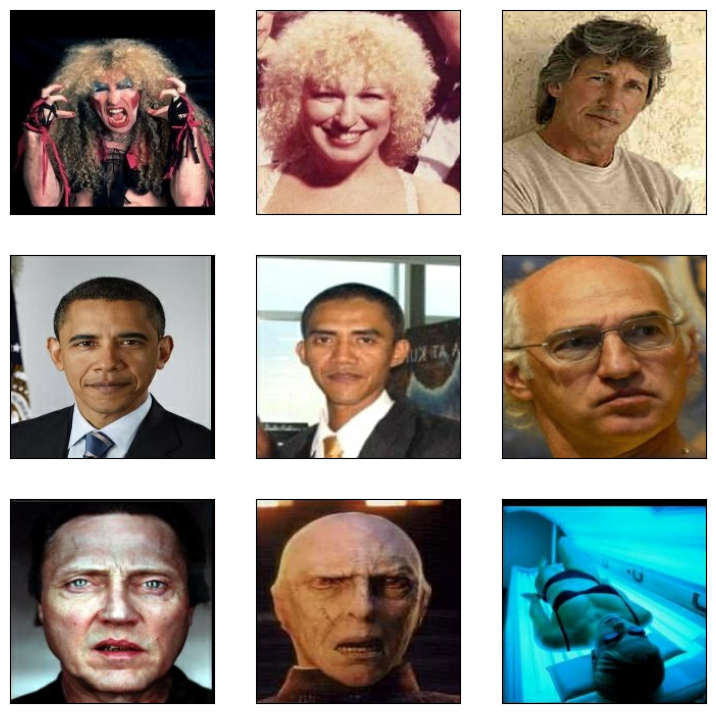

In [6]:
'''
Let's take a look at a few examples of triplets. 
Notice how the first two images look alike while the third one is always different.
'''

def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [ ]:
'''
Setting up the embedding generator model
Our Siamese Network will generate embeddings for each of the images of the triplet. 
To do this, we will use a ResNet50 model pretrained on ImageNet and connect a 
few Dense layers to it so we can learn to separate these embeddings.

We will freeze the weights of all the layers of the model up until the layer conv5_block1_out. 
This is important to avoid affecting the weights that the model has already learned. 
We are going to leave the bottom few layers trainable, so that we can fine-tune their 
weights during training.
'''

